# Initialization

In [56]:
%reload_ext autoreload
%autoreload 2

import os, sys
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import corner

import matplotlib.pyplot as plt

import kdes

# import zcode.math as zmath
# import zcode.plot as zplot

# Basic

## 1D

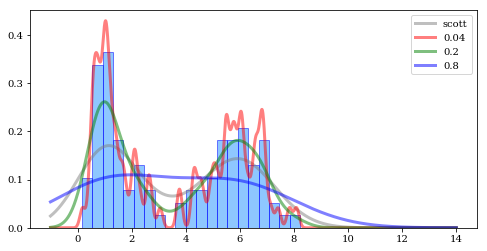

In [2]:
NUM = 100
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bins = kdes.utils.spacing([-1, 14.0], 'lin', 40)
grid = kdes.utils.spacing(bins, 'lin', 3000)

fig, ax = plt.subplots(figsize=[8, 4])
ax.hist(aa, bins=bins, facecolor='dodgerblue', edgecolor='b', alpha=0.5, density=True)

methods = ['scott', 0.04, 0.2, 0.8]
colors = ['0.5', 'r', 'g', 'b']
for mm, cc in zip(methods, colors):
    lab = mm if isinstance(mm, str) else "{:.1f}".format(mm)
    kde = kdes.KDE(aa, bandwidth=mm)
    ax.plot(grid, kde.pdf(grid), color=cc, alpha=0.5, lw=3.0, label=mm)

plt.legend(loc='upper right')
plt.show()

## 2D

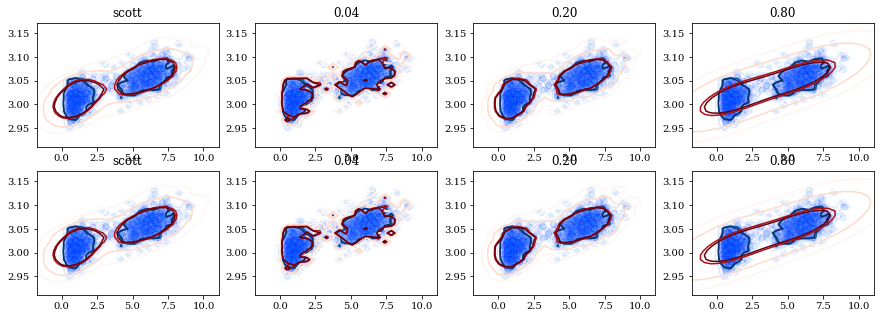

In [33]:
NUM = 1000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kdes.utils.spacing(dd, 'lin', 30, stretch=0.5) for dd in data]
cents = [kdes.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges)
xc, yc = np.meshgrid(*cents)
grid = np.vstack([xc.ravel(), yc.ravel()])


methods = ['scott', 0.04, 0.2, 0.8]

fig, axes = plt.subplots(figsize=[15, 5], ncols=len(methods), nrows=2)
kde_funcs = [sp.stats.gaussian_kde, kdes.KDE]

percs = sp.stats.norm.cdf([-1, 0, 1])
levels = sp.stats.norm.cdf([-2, -1, 1, 2])

for axcol, mm in zip(axes.T, methods):
    lab = mm if isinstance(mm, str) else "{:.2f}".format(mm)
    
    for ax, kdefun in zip(axcol, kde_funcs):
        ax.set_title(lab)

        ax.scatter(*data, facecolor='dodgerblue', edgecolor='b', alpha=0.1)
        hist, *_ = np.histogram2d(*data, bins=edges, density=True)
        ax.contour(xc, yc, hist.T, levels=levels, cmap='Blues')

        kde = kdefun(data, bw_method=mm)
        pdf = kde.pdf(grid).reshape(hist.shape).T
        ax.contour(xc, yc, pdf.T, levels=levels, cmap='Reds')

plt.show()

# Complex

## Different bandwidths per variable

/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Use `bandwidth` instead of `bw_method`


0.6028025867269027
0.7161344718258037


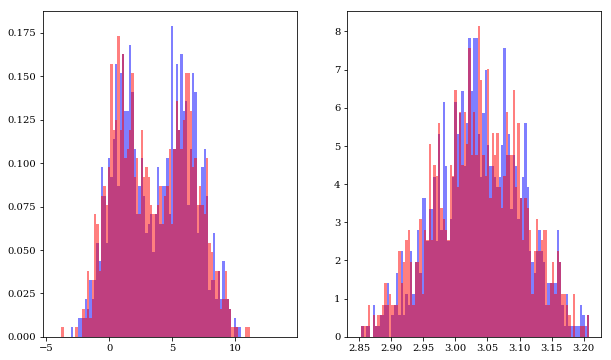

In [5]:
np.random.seed(9235)
NUM = 1000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kdes.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
cents = [kdes.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges)
xc, yc = np.meshgrid(*cents)
grid = np.vstack([xc.ravel(), yc.ravel()])

bws = [0.5, 2.0]

kde2d = kdes.KDE(data, bw_method=bws)

kde1d = [kdes.KDE(dd, bw_method=ss) for dd, ss in zip(data, bws)]

fig, axes = plt.subplots(figsize=[10, 6], ncols=2)

for ii in range(2):
    samp_1d = kde1d[ii].resample(NUM).squeeze()
    samp_2d = kde2d.resample(NUM)[ii]

    ks, pv = sp.stats.ks_2samp(samp_1d, samp_2d)

    ax = axes[ii]
    for samp, cc in zip([samp_1d, samp_2d], ['b', 'r']):
        ax.hist(samp, bins=edges[ii], color=cc, density=True, alpha=0.5)    
    
plt.show()

In [38]:
import corner

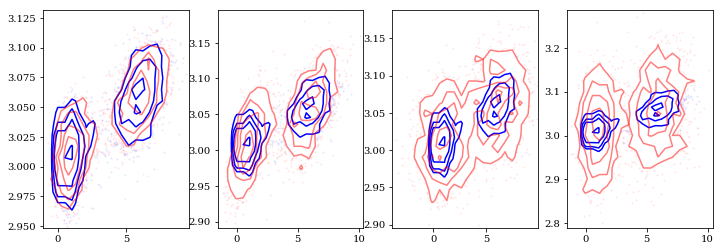

In [55]:
NUM = 2000
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kdes.utils.spacing(dd, 'lin', 30, stretch=1.0) for dd in data]
cents = [kdes.utils.midpoints(ee, 'lin') for ee in edges]

xe, ye = np.meshgrid(*edges)
xc, yc = np.meshgrid(*cents)
grid = np.vstack([xc.ravel(), yc.ravel()])

ss = [0.5, 1.0]
t1 = np.einsum('i,j', ss, ss)
t2 = np.identity(len(ss)) * ss
bws = [0.2, t1, t2, (0.25, 2.)]
fig, axes = plt.subplots(figsize=[12, 4], ncols=len(bws))
levels = sp.stats.norm.cdf([-2, -1, 1, 2])

for ii, (ax, bw) in enumerate(zip(axes, bws)):
    hist, *_ = np.histogram2d(*data, bins=edges, density=True)
    corner.hist2d(*data, plot_density=False, ax=ax, color='blue')
    
    kde = kdes.KDE(data, bw_method=bw)
    pdf = kde.pdf(grid).reshape(hist.shape).T
    samples = kde.resample(NUM)
    corner.hist2d(*samples, plot_density=False, ax=ax, color='red', contour_kwargs=dict(alpha=0.5))

    
plt.show()

## Keep Dimensions in Resample

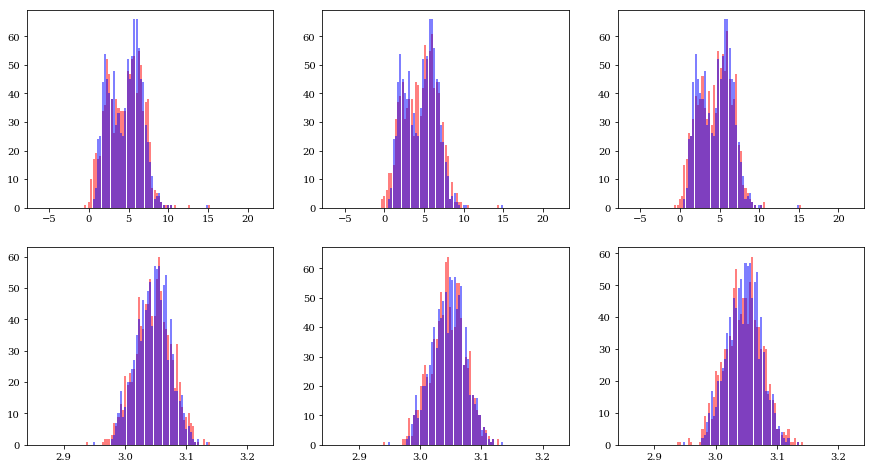

In [58]:
np.random.seed(9235)
NUM = 1000
a1 = np.random.normal(6.0, 1.0, NUM//2)
# a2 = np.random.lognormal(0, 0.5, size=NUM//2)
a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kdes.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
kde2d = kdes.KDE(data)


fig, axes = plt.subplots(figsize=[15, 8], nrows=2, ncols=3)

norm = 2.3

for ii in range(3):
    test = np.array(data)
    test = np.insert(test, ii, norm*np.ones_like(test[0]), axis=0)

    kde3d = kdes.KDE(test)
    
    samples = kde3d.resample(NUM, keep=ii)
    param_samp = samples[ii]
    if not np.allclose(param_samp, norm):
        raise ValueError("Failure!")

    samples = np.delete(samples, ii, axis=0)
    
    for jj in range(2):
        ax = axes[jj, ii]
        stuff = [samples[jj], data[jj]]
        for vals, cc in zip(stuff, ['r', 'b']):
            ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

        ks, pv = sp.stats.ks_2samp(*stuff)
        msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
        # print(msg)
        # zplot.text(ax, msg, loc='ur')
    
plt.show()

In [59]:
np.random.seed(2235)
NUM = 300
a1 = np.random.normal(6.0, 1.0, NUM//2)
# a2 = np.random.lognormal(0, 0.5, size=NUM//2)
a2 = np.random.lognormal(1.0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kdes.utils.spacing(dd, 'lin', 100, stretch=1.0) for dd in data]
kde2d = kdes.KDE(data)


norms = [2.3, -3.4]

pvals = []
for ii in range(3):
    # print("")
    for jj in range(3):
        if ii == jj:
            continue
            
        lo = np.min([ii, jj])
        hi = np.max([ii, jj])
        test = np.array(data)
        test = np.insert(test, lo, norms[0]*np.ones_like(test[0]), axis=0)
        test = np.insert(test, hi, norms[1]*np.ones_like(test[0]), axis=0)

        kde4d = kdes.KDE(test)

        samples = kde4d.resample(NUM, keep=(lo, hi))
#         for kk, samp in enumerate(samples):
#             print(ii, jj, kk, zmath.stats_str(samp))
        
        for kk, ll in enumerate([lo, hi]):
            param_samps = samples[ll]
            if not np.allclose(param_samps, norms[kk]):
                print(norms[kk], zmath.stats_str(param_samps))
                raise ValueError("Failure!")

        samples = np.delete(samples, (lo, hi), axis=0)

        for jj in range(2):
            stuff = [samples[jj], data[jj]]
            for vals, cc in zip(stuff, ['r', 'b']):
                ax.hist(vals, bins=edges[jj], rwidth=0.9, alpha=0.5, color=cc)

            ks, pv = sp.stats.ks_2samp(*stuff)
            msg = "{} {} :: {:.2e} {:.2e}".format(ii, jj, ks, pv)
            pvals.append(pv)
            assert pv > 0.1, print(msg)
            
            
print(np.min(pvals))
print(pvals)


0.13864299127134286
[0.13864299127134286, 0.3823164458071582, 0.5706436774001558, 0.8384236546362508, 0.5039037225904233, 0.5039037225904243, 0.4408260136320148, 0.7090182395773261, 0.28074767044084015, 0.328887598456141, 0.23787970898187208, 0.5039037225904255]


# Boundaries

## Reflecting

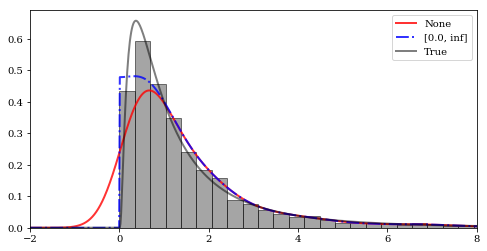

In [88]:
np.random.seed(5142)
NUM = 3000
aa = np.random.lognormal(size=NUM)
# aa = aa[aa < 10.0]

extr = [0.0, 10.0]
edges = kdes.utils.spacing(extr, 'lin', 30)
grid = kdes.utils.spacing(extr, 'lin', 1000, stretch=0.5)

fig, ax = plt.subplots(figsize=[8, 4])

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)


# boundaries = [None, [0.0], [2.0], [0.0, 2.0]]
# lines = ['-', '--', ':', '-.']
boundaries = [None, [0.0, None]]
lines = ['-', '-.']
colors = ['r', 'b']
pdf = sp.stats.lognorm(1.0).pdf(grid)
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kdes.KDE(aa)
    ax.plot(grid, kde.pdf(grid, reflect=bnd), color=cc, ls=ls, lw=2.0, alpha=0.8, label=str(bnd))

ax.plot(grid, pdf, 'k-', label='True', alpha=0.5, lw=2.0)
    
ax.set_xlim([-2, 8])
plt.legend()
plt.show()

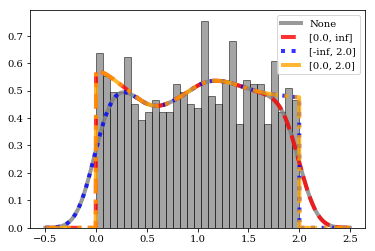

In [62]:
np.random.seed(124)
NUM = 1000
aa = np.random.uniform(0.0, 2.0, NUM)

edges = kdes.utils.spacing(aa, 'lin', 30)
egrid = kdes.utils.spacing(aa, 'lin', 1000, stretch=0.5)
cgrid = kdes.utils.midpoints(egrid, 'lin')
delta = np.diff(egrid)
fig, ax = plt.subplots()

ax.hist(aa, bins=edges, alpha=0.5, color='0.3', edgecolor='k', density=True)

boundaries = [None, [0.0, None], [None, 2.0], [0.0, 2.0]]
lines = ['-', '--', ':', '-.']
colors = ['0.5', 'red', 'blue', 'orange']
for bnd, cc, ls in zip(boundaries, colors, lines):
    kde = kdes.KDE(aa)
    pdf = kde.pdf(cgrid, reflect=bnd)
    ax.plot(cgrid, pdf, color=cc, ls=ls, lw=4.0, alpha=0.8, label=str(bnd))
    
plt.legend()
plt.show()

# Other